In [142]:
#!uv pip install pydub librosa essentia
import os, sys
import json
import librosa
import random
import re
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import freesound
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut, train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, precision_recall_fscore_support, classification_report)
import warnings
from pydub import AudioSegment
import essentia.standard as es
import time
import IPython.display as ipd

warnings.filterwarnings('ignore')

# Part 1
We're given a $10$-second, $44.1$ kHz, $24$-bit stereo WAV containing a melodic phrase played on bass guitar with a pronounced percussive attack. The phrase appears to be transcribed from a flageolett passage, which explains the misleading filename. However, the tags like bass, guitar, and picking confirm that the sound is from a bass guitar.

### Edits made
Using PyDub, the signal is downmixed to mono and resampled/bit-reduced to a $2.5$ second $16$-bit WAV while maintaining the same sample rate. 
| Property                  | Original           | Processed                |
|----------------------------|--------------------------------|----------------------------------|
| Duration (in seconds)                   | 10                           | 2.5                              |
| Sample Rate                | 44.1 kHz                       | 44.1 kHz                         |
| Bit Depth                  | 24-bit                         | 16-bit                           |
| Channels                   | Stereo                          | Mono                             |
### Why this segment?
We choose this $2.5$-second sound fragment because we observe that the the musical material is highly repetitive. A single motif of three notes is repeated three times and comprises $~85\%$ of the total melodic content, followed by a final resolving phrase. We select only the first full repetition of the motif. This segment can act as a good audio thumbnail for the entire sound, and by focusing on this concise, repeated excerpt we can efficiently study the melodic, rhythmic, and harmonic content without loss of generality.

In [143]:
# Load 10-second stereo 24-bit WAV @ 44.1k
original = AudioSegment.from_wav("246219__andreangelo__flageolett-melody.wav")

# Convert to mono, 16-bit, 44.1k, trimmed
converted = (
    original.set_channels(1)
         .set_frame_rate(44100)
         .set_sample_width(2)     # 16-bit = 2 bytes
         [:2461]                  # one full repetition of the motif
)

# Export
converted.export("flageolett_processed.wav", format="wav")

# Listen to both sounds
print("Original 10-second WAV")
ipd.display(ipd.Audio(original.export(format="wav").read()))
processed = AudioSegment.from_wav("flageolett_processed.wav")
print("Processed 2-second WAV")
ipd.display(ipd.Audio(processed.export(format="wav").read()))

Original 10-second WAV


Processed 2-second WAV


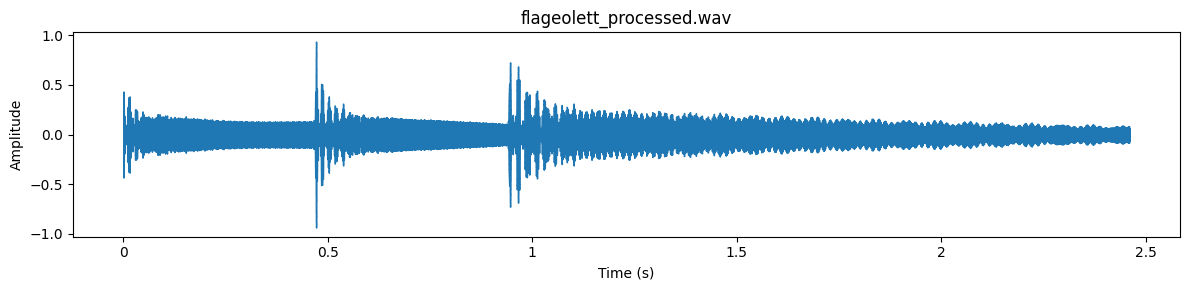

In [144]:
# Load the edited WAV file
y, sr = librosa.load("flageolett_processed.wav", sr=44100, mono=True)
duration = len(y) / sr

# Display waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("flageolett_processed.wav")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

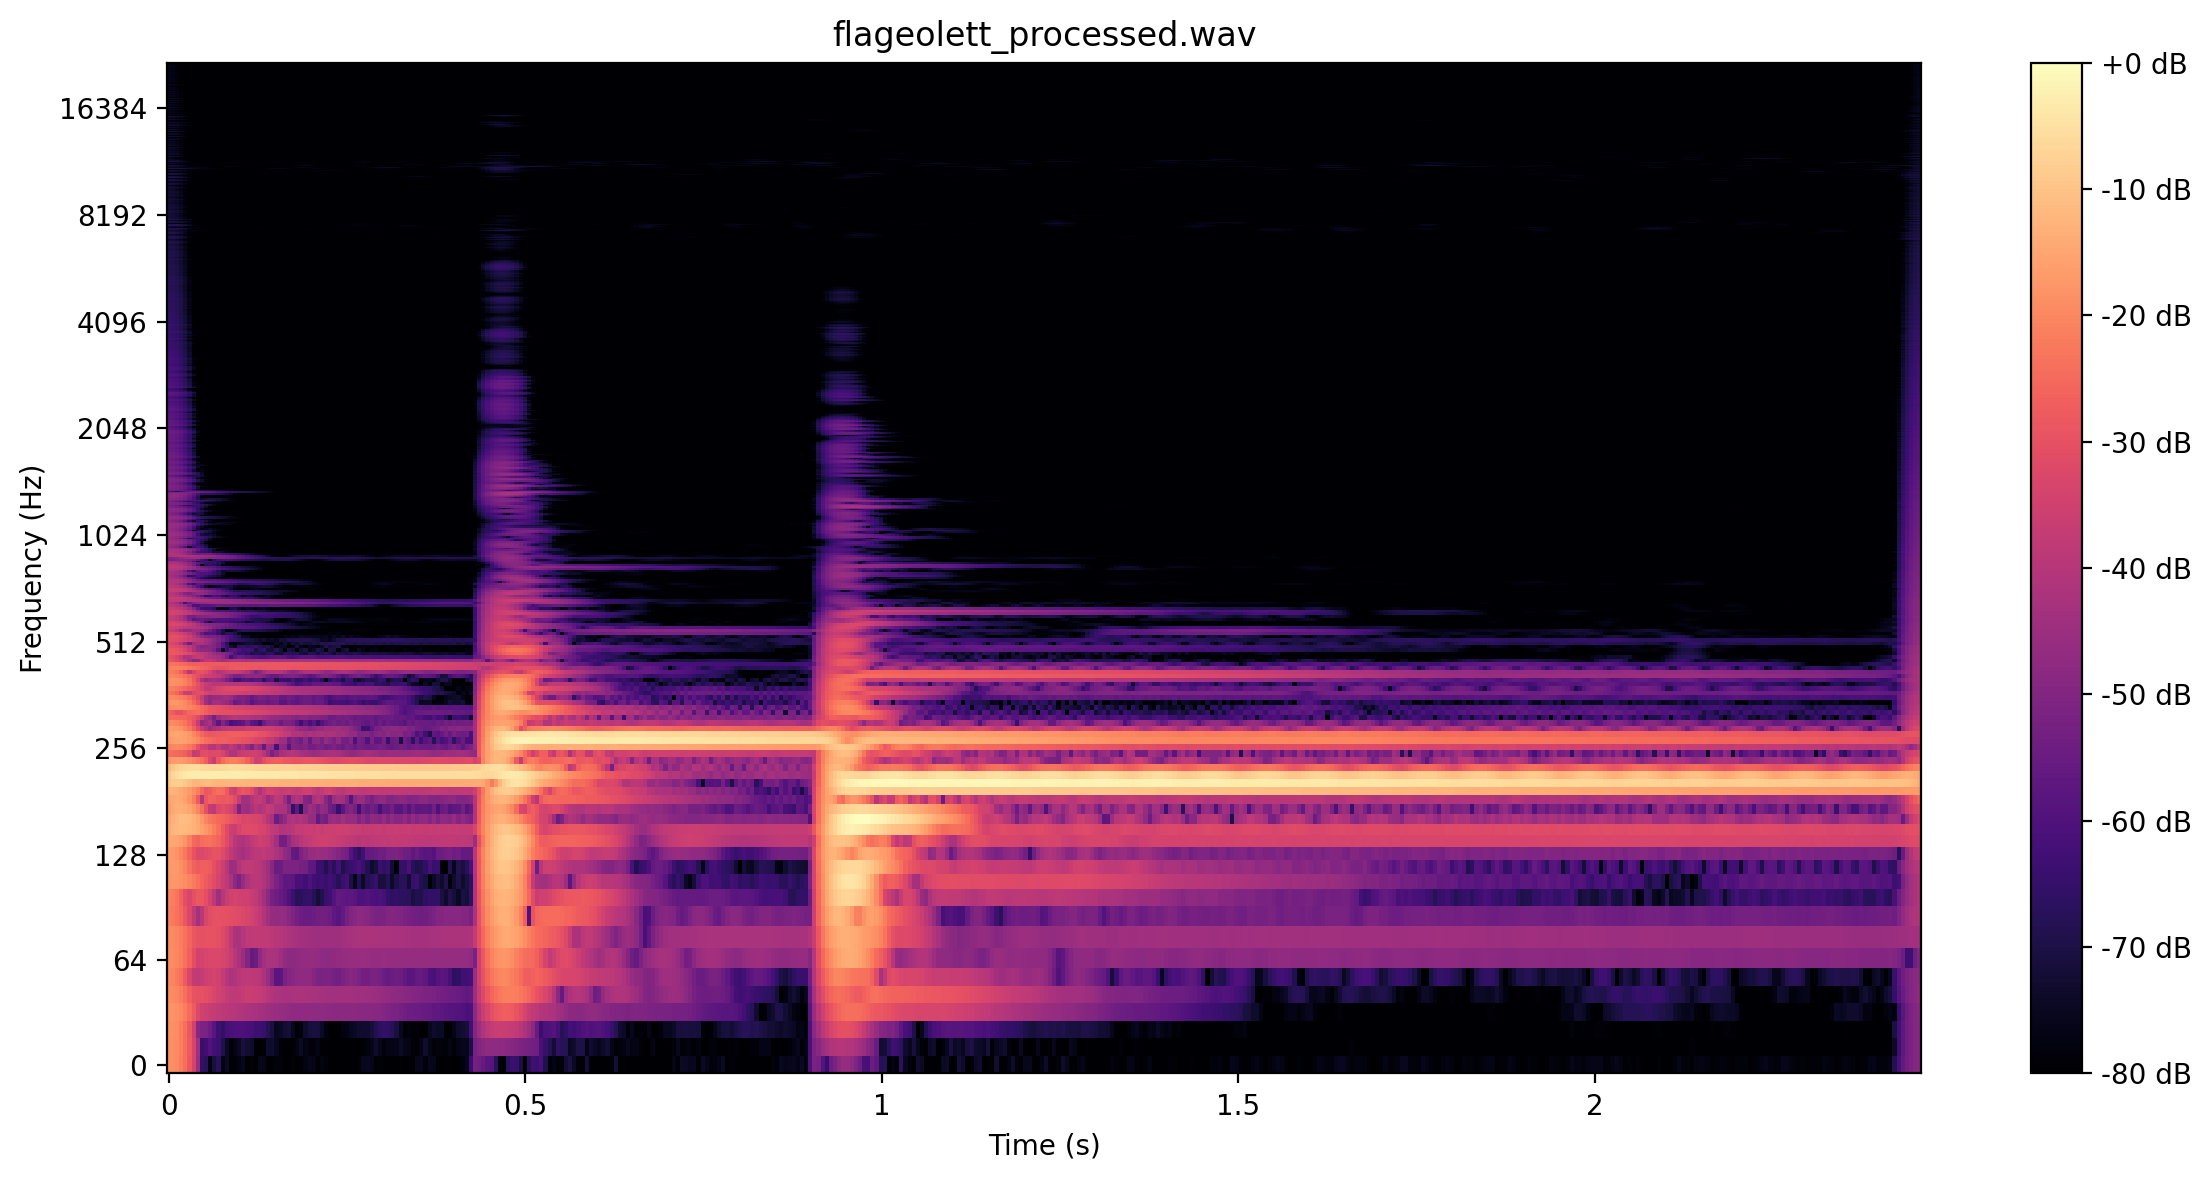

In [145]:
# Set parameters for STFT
n_fft = 4096         # freq resolution not too high, not too low
hop_length = 256     
window = 'hann'

# Get STFT
S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))
S_db = librosa.amplitude_to_db(S, ref=np.max)

# Plot log-magnitude spectrograms
plt.figure(figsize=(12, 6), dpi=200)
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='magma', vmin=-80, vmax=0)
plt.colorbar(format='%+2.0f dB')
plt.title("flageolett_processed.wav")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

### Description of sound using temporal representation
The beginning of each note (around $0$ s, $0.5$ s, and $0.9$ s) shows a rapid vertical burst of energy across a wide frequency range. These attack transients are short-duration, high-energy, non-sinusoidal events. The notes exhibit a slow decay in magnitude (color intensity fades) after the initial attack, characteristic of a plucked or bowed instrument like a bass.

### Description of sound using spectral representation
Since this is an acoustic bass, the most significant energy is concentrated in the low-frequency range (below $512$ Hz). The lowest and thickest line of energy is the fundamental frequency, which can be observed for all three notes between 30Hz to 90Hz. The sound exhibits a clear set of multiple, regularly spaced horizontal lines extending up from the fundamental, which are the harmonics.

### Implication for choice of spectral model
| Aspect     | Observations                                           | Implication for choice of spectral Model                                                                 | Parameter Decision                                                                 |
|------------|-----------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------|
| Attack  | Short broadband vertical bursts of  high energy          | Attacks are non-sinusoidal so we can use the harmonic plus residual model. The attack energy will be captured primarily by the residual component | Small hop size to track rapid amplitude changes |
| Sustain | Long duration notes with slow decay in magnitude                | Harmonic component needs to be tracked smoothly over time                   | High overlap to ensure smooth tracking of harmonic evolution |
|f0      | Lowest f0 is between 30Hz to 90Hz for all notes                               | Requires high frequency resolution to clearly separate f0 from the first harmonic | Large FFT size and long window are preferable|
| Harmonics | Clear, regularly spaced horizontal harmonics            | Harmonic Model is appropriate for the steady-state components        | Accurate peak-picking algorithms are required, with attention to harmonic spacing |

### Evidence for our description

Since we believe the harmonic plus stochastic (HPS) model would be ideal for modelling this sound, we provide below a harmonicity analysis of the spectrum. We can observe long steady-state regions with high harmonicity and short stochastic regions with lower harmonicity (transients). This provides evidence that the HPS model is appropriate for modeling this sound.

We additionally perform an HPS analysis using the SMS tools GUI interface. Using parameters guided by the table above, we verify that the sound can be analyzed successfully with the harmonic plus stochastic model. The reconstructed sound using HPS, the parameters, and the image from the HPS analysis is available [in this Google Drive folder](https://drive.google.com/drive/folders/1gGFEiJDR4gTC9pCtn7mKHTO_4dzRhkaB?usp=sharing).

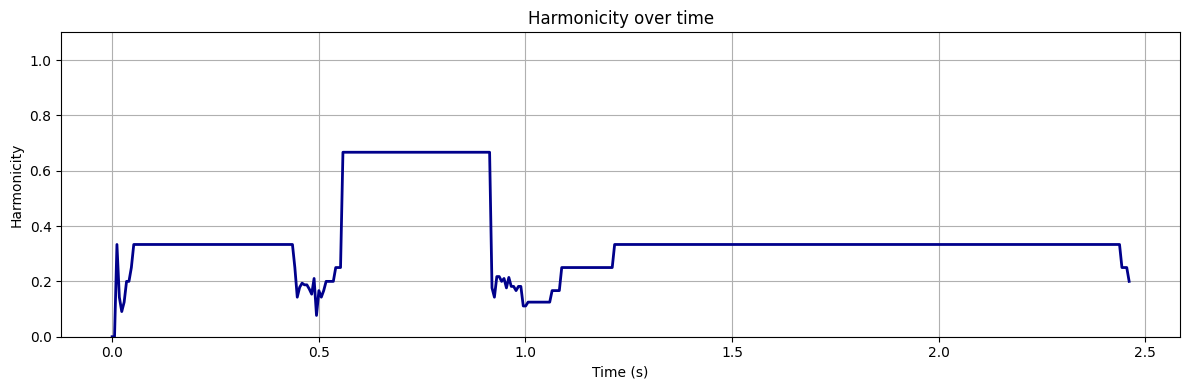



Additionally, the reconstructed sound using HPS, the parameters, and the image from the HPS analysis is available in this Google Drive folder: https://drive.google.com/drive/folders/1gGFEiJDR4gTC9pCtn7mKHTO_4dzRhkaB?usp=sharing




In [146]:
# Get fft frequencies
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# Harmonicity calculation
harmonicity = []

# Loop over each frame of the STFT
# And find indices of spectral bins above the threshold
for frame in S.T:
    thresh = frame.max() * 0.2
    peaks = np.where(frame > thresh)[0]

    # Skip frames with few peaks and avoid divide-by-zero
    if len(peaks) < 2 or freqs[peaks[0]] < 1e-6:
        harmonicity.append(0)
        continue
    ratios = freqs[peaks] / freqs[peaks[0]]

    # Count how many peaks are close to integer multiples of the fundamental
    # And normalize to get harmonicity between 0 and 1
    harmonicity.append(np.sum(np.abs(ratios - np.round(ratios)) < 0.05) / len(peaks))

# Get time axis
time = np.linspace(0, duration, len(harmonicity))

# Plot harmonicity
plt.figure(figsize=(12,4))
plt.plot(time, harmonicity, color='darkblue', lw=2)
plt.ylim(0,1.1)
plt.xlabel("Time (s)")
plt.ylabel("Harmonicity")
plt.title("Harmonicity over time")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n\nAdditionally, the reconstructed sound using HPS, the parameters, and the image from the HPS analysis is available in this Google Drive folder: https://drive.google.com/drive/folders/1gGFEiJDR4gTC9pCtn7mKHTO_4dzRhkaB?usp=sharing\n\n")

# Part 2 (c): Sound classification

# Part 2.1: Sound analysis using Essentia

We analyse our sound with five low-level audio descriptors from essentia, which are present in the Freesound extractor. Our choices are driven primarily by the fact that the acoustic bass in the audio sounds 'smooth' and 'round' and is heavy on the low-end. Our rationale behind choosing our descriptors is provided below: 

| Descriptor                       | Why it's useful for analysing our sound                                                                 |
|----------------------------------|------------------------------------------------------------------------------------------------------------------------|
| lowlevel.spectral_centroid.mean   | Measures the "brightness" of the sound. A round bass typically has a low spectral centroid because it emphasizes low frequencies |
| lowlevel.dissonance.mean          | Quantifies roughness or harmonic tension. For a smooth, round bass, dissonance is usually low, capturing its pleasant harmonic quality |
| lowlevel.hfc.mean                 | High-Frequency Content indicates the amount of energy in high frequencies. A round bass has low HFC since it’s mellow and not bright |
| lowlevel.spectral_contrast.mean        | Captures differences between peaks and valleys in the spectrum. Useful to highlight the strong low-frequency fundamentals versus weaker overtones in a round bass |
| lowlevel.mfcc.mean                     | Mel-Frequency Cepstral Coefficients encode timbral texture. MFCCs are ideal for capturing the characteristic warmth and tone of a round acoustic bass |


In [147]:
import essentia.standard as es

# Input file
input_file = "flageolett_processed.wav"

# Load audio and extract features using MusicExtractor
print("Analyzing audio file with Essentia MusicExtractor...")
print(f"File: {input_file}\n")

# Run MusicExtractor
extractor = es.MusicExtractor(lowlevelStats=['mean'])
features, features_frames = extractor(input_file)

# Descriptors to extract
descriptors = [
    'lowlevel.spectral_centroid.mean',
    'lowlevel.dissonance.mean',
    'lowlevel.hfc.mean',
    'lowlevel.spectral_contrast_coeffs.mean',
    'lowlevel.mfcc.mean'
]

print("=" * 60)
print("EXTRACTING AUDIO DESCRIPTORS")
print("=" * 60)

# Check which keys exist and handle both scalars and arrays
for desc in descriptors:
    try:
        value = features[desc]
        
        # Check if value is an array or scalar
        if isinstance(value, (list, np.ndarray)):
            # For arrays, display the array and its mean
            mean_value = np.mean(value)
            print(f"{desc:45s} : {mean_value:.6f}")
        else:
            # For scalars, just display the value
            print(f"{desc:45s} : {value:.6f}")
            
    except KeyError:
        print(f"{desc:45s} : NOT FOUND")
        
        # Try to find similar keys
        base_key = desc.rsplit('.', 1)[0]
        print(f"  Searching for alternatives to '{base_key}'...")
        
        # Search for similar keys in the pool
        matching_keys = [key for key in features.descriptorNames() if base_key.split('.')[-1] in key]
        if matching_keys:
            print(f"  Found similar keys: {matching_keys[:3]}")

print("=" * 60)

Analyzing audio file with Essentia MusicExtractor...
File: flageolett_processed.wav

EXTRACTING AUDIO DESCRIPTORS
lowlevel.spectral_centroid.mean               : 222.843826
lowlevel.dissonance.mean                      : 0.206050
lowlevel.hfc.mean                             : 5.822074
lowlevel.spectral_contrast_coeffs.mean        : -0.794410
lowlevel.mfcc.mean                            : -62.759075


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


# Part 2.2: Create and analyse sound collections

### Define API key, sound collections, and descriptors

In [148]:
API_Key = "3fS7Wd7vupgdukvnSAqgbTQ5w01ZRhedNfj6j9TP"
fsClnt = freesound.FreesoundClient()
fsClnt.set_token(API_Key, "token")

# Descriptors that don't return vectors
core_descriptors = [
    'lowlevel.spectral_centroid.mean',
    'lowlevel.dissonance.mean',
    'lowlevel.hfc.mean'
    # 'sfx.logattacktime.mean',
    # 'sfx.inharmonicity.mean'
]

# Descriptors that return vectors (all 6 bands and all 13 coefficients)
vector_descriptors_base = [
    'lowlevel.spectral_contrast',
    'lowlevel.mfcc'
]

all_fs_descriptors = core_descriptors + vector_descriptors_base
descriptor_string = ",".join(all_fs_descriptors)

# Five collections of chosen sounds (7 sounds in each instrument)
instrument_sounds = {
    'congo': ["https://freesound.org/people/mkoenig/sounds/43540/", "https://freesound.org/people/mkoenig/sounds/43541/", "https://freesound.org/people/stoltingmediagroup/sounds/601894/", "https://freesound.org/people/stoltingmediagroup/sounds/601893/", "https://freesound.org/people/stoltingmediagroup/sounds/601892/", "https://freesound.org/people/stoltingmediagroup/sounds/601891/", "https://freesound.org/people/stoltingmediagroup/sounds/601890/"],
    'flute': ["https://freesound.org/people/MTG/sounds/246710/", "https://freesound.org/people/MTG/sounds/246709/", "https://freesound.org/people/MTG/sounds/246708/", "https://freesound.org/people/MTG/sounds/246707/", "https://freesound.org/people/MTG/sounds/246706/", "https://freesound.org/people/MTG/sounds/246705/", "https://freesound.org/people/MTG/sounds/246704/"],
    'guitar': ["https://freesound.org/people/Skamos66/sounds/399505/", "https://freesound.org/people/Skamos66/sounds/399504/", "https://freesound.org/people/Skamos66/sounds/399503/", "https://freesound.org/people/Skamos66/sounds/399502/", "https://freesound.org/people/Skamos66/sounds/399501/", "https://freesound.org/people/Skamos66/sounds/399500/", "https://freesound.org/people/Skamos66/sounds/399499/"],
    'piano': ["https://freesound.org/people/Sadiquecat/sounds/794376/", "https://freesound.org/people/Sadiquecat/sounds/794374/", "https://freesound.org/people/Sadiquecat/sounds/794373/", "https://freesound.org/people/VizAion/sounds/795601/", "https://freesound.org/people/Sadiquecat/sounds/794434/", "https://freesound.org/people/Sadiquecat/sounds/794462/", "https://freesound.org/people/Sadiquecat/sounds/794437/"],
    'violin': ["https://freesound.org/people/MTG/sounds/247459/", "https://freesound.org/people/MTG/sounds/247456/", "https://freesound.org/people/MTG/sounds/247455/", "https://freesound.org/people/MTG/sounds/247453/", "https://freesound.org/people/MTG/sounds/247452/", "https://freesound.org/people/MTG/sounds/247450/", "https://freesound.org/people/MTG/sounds/247876/"]
}

# Column mapping
column_map = {
    'lowlevel.spectral_centroid.mean': 'spectral_centroid',
    'lowlevel.dissonance.mean': 'dissonance',
    'lowlevel.hfc.mean': 'hfc',
    'lowlevel.spectral_contrast': 'spectral_contrast',
    'lowlevel.mfcc': 'mfcc'
}

### Helper functions for fetching using Freesound API

In [149]:
def get_sound_id_from_url(url):
    """Extracts the numerical sound ID from a Freesound URL."""
    match = re.search(r'/sounds/(\d+)/', url)
    return int(match.group(1)) if match else None

def fetch_descriptors_persistent_retry(client, sound_id, descriptors_str):
    """
    Fetches sound data with descriptors, retrying indefinitely with exponential backoff
    until a successful retrieval (or a non-retryable error) occurs.
    """
    attempt = 0
    # Use a while True loop to retry indefinitely
    while True:
        try:
            sound_obj = client.get_sound(
                sound_id,
                fields="id,name,analysis,url",
                descriptors=descriptors_str
            )

            analysis_data = getattr(sound_obj, 'analysis', None)

            if analysis_data is None:
                print(f"  ⚠️ Sound {sound_id}: No Analysis Data available.")
                # Non-retryable condition: Analysis data is explicitly missing for this sound.
                return {'sound_id': sound_id, 'url': getattr(sound_obj, 'url', 'N/A'), 'status': 'No Analysis Data'}

            # Initial extraction dict
            extracted = {
                'sound_id': sound_id,
                'name': getattr(sound_obj, 'name', 'N/A'),
                'url': getattr(sound_obj, 'url', 'N/A')
            }

            for d in all_fs_descriptors:
                value = analysis_data
                parts = d.split('.')
                
                # Navigate the nested analysis structure
                for part in parts:
                    value = getattr(value, part, None)
                    if value is None: break

                # Handle scalar mean values
                if d in core_descriptors:
                    extracted[d] = value
                
                # Handle vector values (MFCC, Spectral Contrast)
                elif d in vector_descriptors_base and value is not None:
                    mean_vector = getattr(value, 'mean', None)
                    extracted[d] = mean_vector
                else:
                    extracted[d] = None
            
            # SUCCESS: Break the infinite loop and return the data
            return extracted

        except freesound.FreesoundException as e:
            error_code = getattr(e, 'code', None)
            
            # Check for retryable errors (typically 5xx server errors)
            if error_code in [429, 500, 502, 503, 504]:
                attempt += 1
                
                # Base sleep time is 5 seconds, doubled linearly, plus jitter
                sleep_time = (5 * attempt) + random.uniform(0, 1)
                
                print(f"  ⚠️ Server Error ({error_code}) on {sound_id}. Attempt {attempt}. Retrying in {sleep_time:.2f}s...")
                time.sleep(sleep_time)
                
            # Handle non-retryable API errors (e.g., 404 Not Found, 401 Unauthorized)
            else:
                print(f"Fatal API Error ({error_code}) on {sound_id}: {e}. Skipping.")
                return {'sound_id': sound_id, 'url': 'N/A', 'status': 'Failed', 'error': str(e)}

        except Exception as e:
            # Catch unexpected Python errors
            attempt += 1
            print(f"Unexpected System Error on {sound_id}: {e}. Retrying in 10s...")
            time.sleep(10)

### Fetch descriptors of sound collections from Freesound

In [150]:
import time 

all_results = []
print("--- Starting Freesound Descriptor Fetch ---")

for label, urls in instrument_sounds.items():
    print(f"\n--- Processing {label.lower()} sounds (Total: {len(urls)}) ---")
    for url in urls:
        sound_id = get_sound_id_from_url(url)
        if sound_id is None:
            print(f"  Skipping URL: Could not extract ID from {url}")
            continue

        print(f"  Fetching ID: {sound_id} ({label})...")
        
        # Use the persistent retry function
        data = fetch_descriptors_persistent_retry(fsClnt, sound_id, descriptor_string)
        
        # Introduce a minimal delay between sounds to not overload the API
        time.sleep(0.5) 

        if data:
            data['instrument'] = label # New column name
            all_results.append(data)

--- Starting Freesound Descriptor Fetch ---

--- Processing congo sounds (Total: 7) ---
  Fetching ID: 43540 (congo)...
  Fetching ID: 43541 (congo)...
  Fetching ID: 601894 (congo)...
  Fetching ID: 601893 (congo)...
  Fetching ID: 601892 (congo)...
  Fetching ID: 601891 (congo)...
  Fetching ID: 601890 (congo)...
  ⚠️ Server Error (503) on 601890. Attempt 1. Retrying in 5.65s...
  ⚠️ Server Error (503) on 601890. Attempt 2. Retrying in 10.52s...

--- Processing flute sounds (Total: 7) ---
  Fetching ID: 246710 (flute)...
  Fetching ID: 246709 (flute)...
  Fetching ID: 246708 (flute)...
  Fetching ID: 246707 (flute)...
  Fetching ID: 246706 (flute)...
  Fetching ID: 246705 (flute)...
  Fetching ID: 246704 (flute)...

--- Processing guitar sounds (Total: 7) ---
  Fetching ID: 399505 (guitar)...
  Fetching ID: 399504 (guitar)...
  Fetching ID: 399503 (guitar)...
  Fetching ID: 399502 (guitar)...
  Fetching ID: 399501 (guitar)...
  Fetching ID: 399500 (guitar)...
  Fetching ID: 399499 (g

### Create dataframe and rename columns

In [151]:
# Convert the list of dictionaries to a pandas dataframe
df = pd.DataFrame(all_results)

# Rename the simple mean columns
df.rename(columns=column_map, inplace=True)
df.rename(columns={'name': 'sound_name'}, inplace=True)

# Explode the vector columns (MFCC and Spectral Contrast)
# Handle potential missing/empty lists by ensuring the correct length is created
# Spectral Contrast (6 bands)
sc_series = df.pop('spectral_contrast').apply(lambda x: x if isinstance(x, list) and len(x) == 6 else [None]*6)
sc_df = pd.DataFrame(sc_series.tolist(), index=df.index,
                     columns=[f'spectral_contrast_{i}' for i in range(1, 7)])
df = pd.concat([df, sc_df], axis=1)

# MFCC (13 coefficients)
mfcc_series = df.pop('mfcc').apply(lambda x: x if isinstance(x, list) and len(x) == 13 else [None]*13)
mfcc_df = pd.DataFrame(mfcc_series.tolist(), index=df.index,
                      columns=[f'mfcc_{i}' for i in range(1, 14)])
df = pd.concat([df, mfcc_df], axis=1)

# Final Column Ordering
final_cols_order = [
    'instrument', 'sound_id', 'url', 'sound_name',
    'spectral_centroid', 'dissonance', 'hfc',
    #'log_attack_time', 'inharmonicity',
    'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
    'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
    'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
    'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
    'status', 'error'
]

# Select and reorder columns, only keeping those that exist
df = df.reindex(columns=[c for c in final_cols_order if c in df.columns])

print(f"DataFrame created with {len(df)} records.")

# Save to CSV
# df.to_csv('freesound_descriptors_expanded.csv', index=False)

DataFrame created with 35 records.


In [152]:
df.head(10)

instrument  sound_id                                                url  \
0      congo     43540  https://freesound.org/people/mkoenig/sounds/43...   
1      congo     43541  https://freesound.org/people/mkoenig/sounds/43...   
2      congo    601894  https://freesound.org/people/stoltingmediagrou...   
3      congo    601893  https://freesound.org/people/stoltingmediagrou...   
4      congo    601892  https://freesound.org/people/stoltingmediagrou...   
5      congo    601891  https://freesound.org/people/stoltingmediagrou...   
6      congo    601890  https://freesound.org/people/stoltingmediagrou...   
7      flute    246710    https://freesound.org/people/MTG/sounds/246710/   
8      flute    246709    https://freesound.org/people/MTG/sounds/246709/   
9      flute    246708    https://freesound.org/people/MTG/sounds/246708/   

                                     sound_name  spectral_centroid  \
0                                congo3_130.wav         410.009164   
1                                 congo_130.wav         924.078414   
2           SMG_Sound_Perc_Congo_1731445779.wav         135.419551   
3           SMG_Sound_Perc_Congo_0492714315.wav         253.981311   
4           SMG_Sound_Perc_Congo_1550976583.wav         142.000292   
5           SMG_Sound_Perc_Congo_1004879273.wav         330.185510   
6           SMG_Sound_Perc_Congo_1592428094.wav         244.978203   
7  overall quality of single note - flute - A#6        1776.405400   
8  overall quality of single note - flute - A#6        2318.375106   
9  overall quality of single note - flute - A#6        1875.214817   

   dissonance         hfc  spectral_contrast_1  spectral_contrast_2  \
0    0.381022   33.564193            -0.461504            -0.668595   
1    0.383157    7.942233            -0.543577            -0.718116   
2    0.441514   62.177408            -0.282846            -0.748755   
3    0.345515  107.359820            -0.230586            -0.654036   
4    0.283213   49.146550            -0.331381            -0.681706   
5    0.338531  133.087663            -0.204987            -0.460704   
6    0.365056   29.024645            -0.392333            -0.778247   
7    0.476080   15.726398            -0.706682            -0.822315   
8    0.470307    5.286021            -0.688397            -0.808901   
9    0.482802    2.656143            -0.694426            -0.820246   

   spectral_contrast_3  ...     mfcc_4     mfcc_5     mfcc_6     mfcc_7  \
0            -0.739095  ...  -1.142888 -22.040478 -12.792707 -15.784542   
1            -0.777275  ...  -5.390123 -18.231129 -14.305523 -14.367562   
2            -0.836501  ...  97.490064  23.185643  50.719912   8.739070   
3            -0.639108  ... -40.104473 -51.853037  -9.202707   7.099337   
4            -0.808037  ...  62.473181  16.998424  15.483797   0.107842   
5            -0.669968  ... -80.115857 -49.470969   0.944166 -17.351301   
6            -0.797028  ...  -8.207908  -3.345196  -9.668350  -3.216833   
7            -0.808159  ... -25.667495  25.158641  19.819110  -1.251559   
8            -0.783959  ... -37.877757  20.858988  18.029457   3.379325   
9            -0.816863  ... -24.218340  21.526704  22.097830  -0.148354   

      mfcc_8     mfcc_9    mfcc_10    mfcc_11    mfcc_12    mfcc_13  
0  -5.517698  -1.864630  -3.159299  -5.232468  -8.821266  -9.093506  
1  -5.877151  -1.071150  -2.061916  -4.048374  -8.155294  -8.008061  
2  15.892800  -5.079284  11.789302 -10.010462   5.974774 -15.677055  
3 -13.076273 -37.200283 -31.104903 -11.977147  -4.608845 -19.883227  
4   3.840533  -4.671609  -1.739433  -7.992401  -0.982970  -8.778761  
5 -50.962109 -42.941142 -12.274383 -13.246768 -35.449966 -35.480621  
6 -14.979377  -5.389296 -21.003830 -10.387610 -18.319567 -14.516631  
7 -23.888456  18.814360  29.879929  15.761654  -8.826759  30.197008  
8 -22.323569  22.987368  24.648459  18.435111  -2.540499  31.175370  
9 -18.214005  16.527783  24.871909  18.539107   2.084373  23.879188  

[10 

### Hand-crafted descriptors

In [153]:
# Spectral contrast statistics
sc_cols = [c for c in df.columns if 'spectral_contrast' in c]
df['spectral_contrast_mean'] = df[sc_cols].mean(axis=1)
df['spectral_contrast_std'] = df[sc_cols].std(axis=1)
df['spectral_contrast_range'] = df[sc_cols].max(axis=1) - df[sc_cols].min(axis=1)

# MFCC statistics
mfcc_cols = [c for c in df.columns if 'mfcc' in c]
df['mfcc_mean'] = df[mfcc_cols].mean(axis=1)
df['mfcc_std'] = df[mfcc_cols].std(axis=1)
df['mfcc_range'] = df[mfcc_cols].max(axis=1) - df[mfcc_cols].min(axis=1)

# Brightness (spectral centroid normalized by HFC)
df['brightness'] = df['spectral_centroid'] * df['hfc']

### Analyze the five sound collections with chosen descriptors

In [154]:
INSTRUMENTS = ['congo', 'flute', 'guitar', 'piano', 'violin']

print("\n" + "="*45)
print("Which descriptors are most discriminative?")
print("="*45)

# Select key features for analysis
key_features = ['spectral_centroid', 'dissonance', 'hfc', 
                'spectral_contrast_mean', 'mfcc_mean', 'brightness']
                #'timbre_complexity', #'attack_sharpness', #'log_attack_time', 'inharmonicity']

# Perform ANOVA to find most discriminative features
print("\nANOVA F-statistics (higher = more discriminative):\n")
anova_results = []
for feature in key_features:
    groups = [df[df['instrument'] == inst][feature].values for inst in INSTRUMENTS]
    f_stat, p_val = stats.f_oneway(*groups)
    anova_results.append({'Feature': feature, 'F-statistic': f_stat, 'P-value': p_val})

anova_df = pd.DataFrame(anova_results).sort_values('F-statistic', ascending=False)
print(anova_df)


Which descriptors are most discriminative?

ANOVA F-statistics (higher = more discriminative):

                  Feature  F-statistic       P-value
1              dissonance    16.502854  2.989205e-07
4               mfcc_mean     9.771853  3.490934e-05
0       spectral_centroid     5.742550  1.484825e-03
3  spectral_contrast_mean     5.164609  2.750031e-03
2                     hfc     4.081536  9.285795e-03
5              brightness     2.418510  7.036910e-02


### Visualize distribution of descriptors and instrument separation 

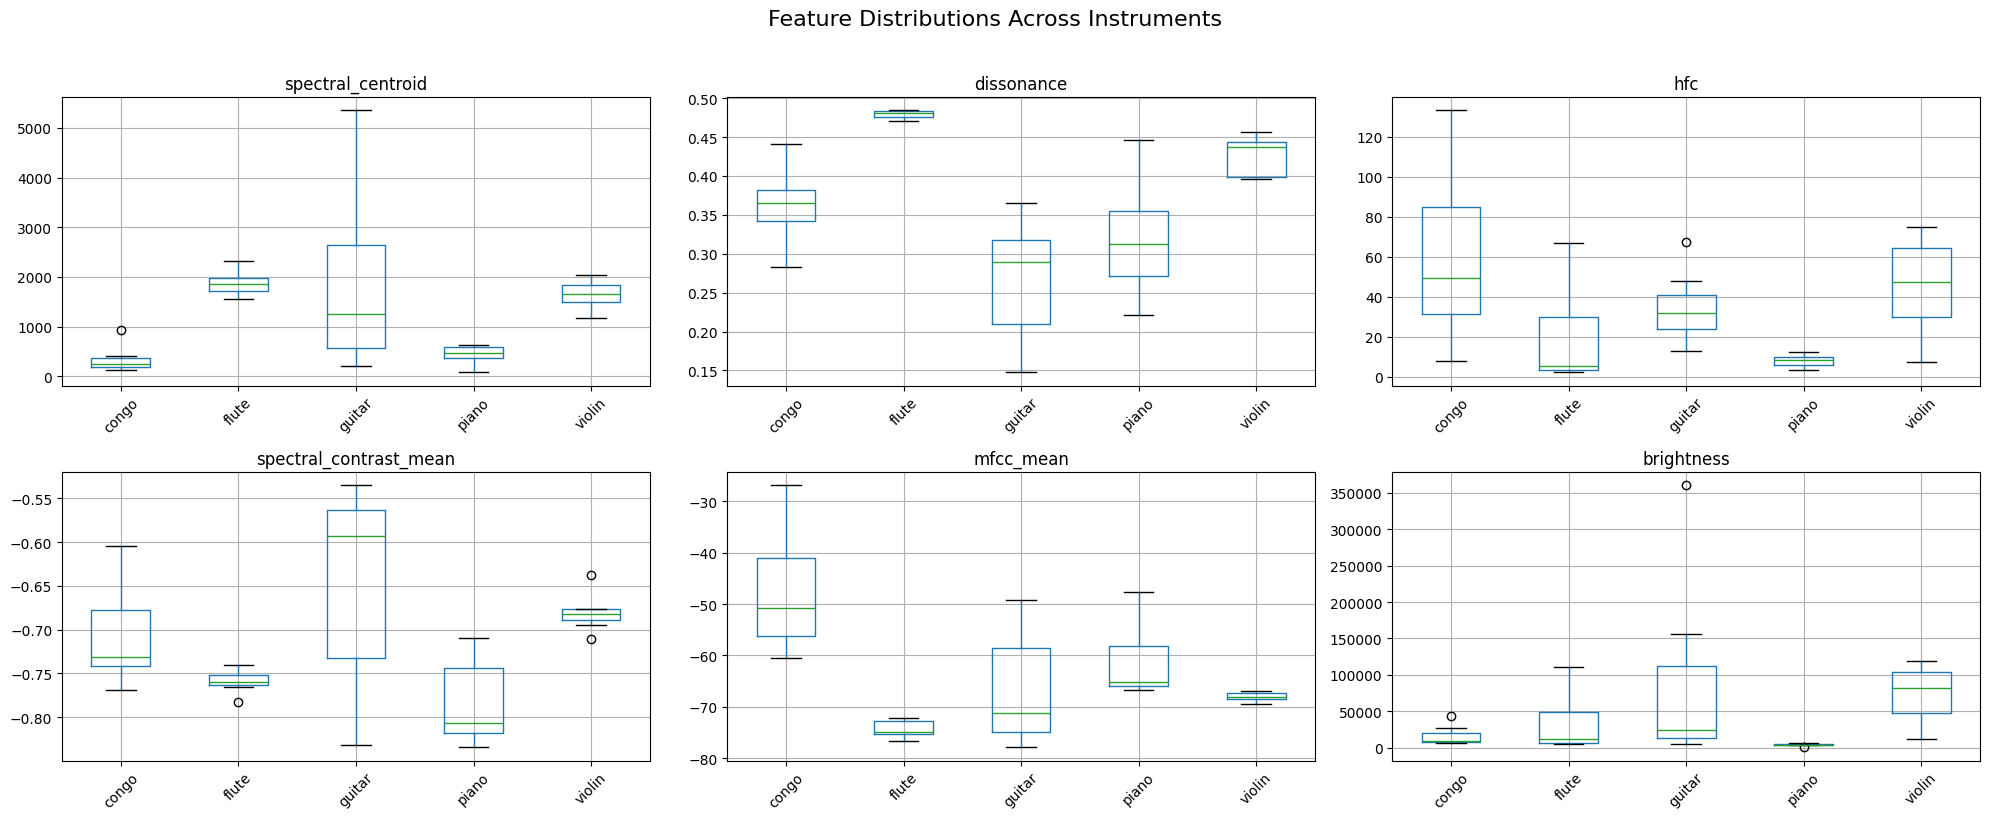

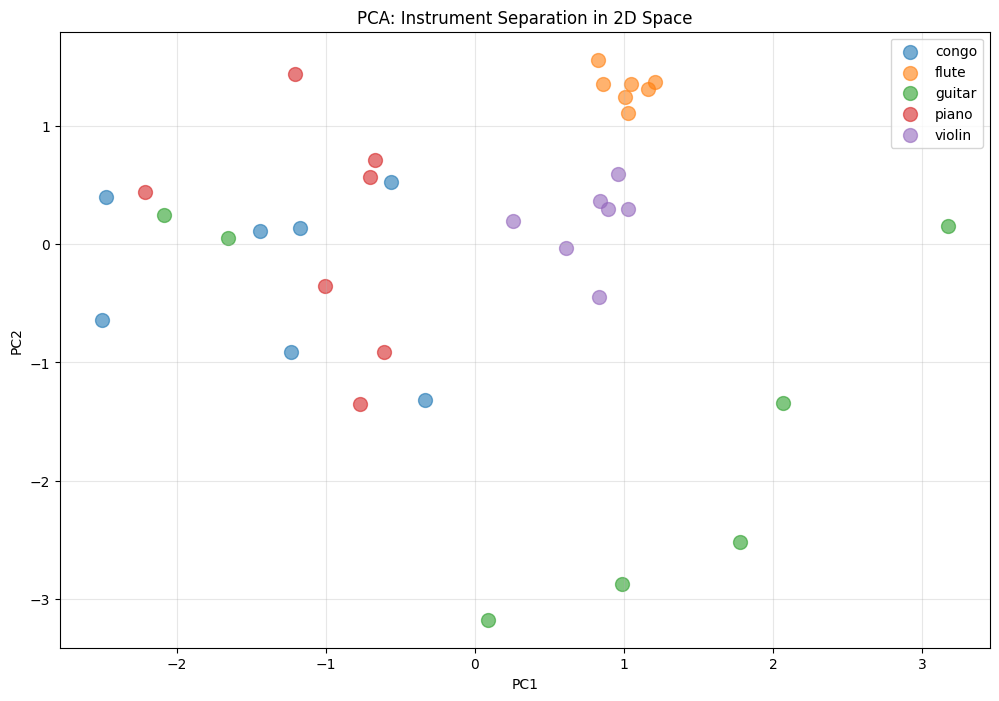

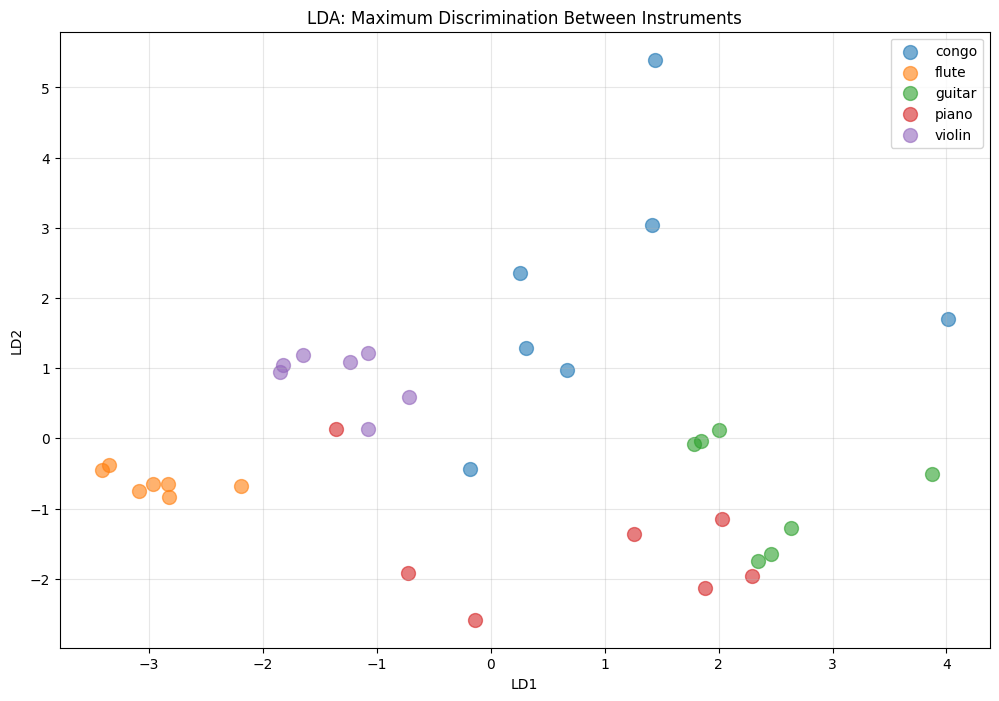

In [155]:
# Visualization: Feature distributions across instruments
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    df.boxplot(column=feature, by='instrument', ax=axes[idx])
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel('')
    plt.sca(axes[idx])
    plt.xticks(rotation=45)

plt.suptitle('Feature Distributions Across Instruments', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Select a few highly discriminative features
selected_features = ['dissonance', 'mfcc_mean', 'spectral_centroid','spectral_contrast_mean']

# Visualization: PCA for dimensionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[selected_features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for instrument in INSTRUMENTS:
    mask = df['instrument'] == instrument
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=instrument, alpha=0.6, s=100)

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('PCA: Instrument Separation in 2D Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualization: LDA for maximum class separation
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, df['instrument'])

plt.figure(figsize=(12, 8))
for instrument in INSTRUMENTS:
    mask = df['instrument'] == instrument
    plt.scatter(X_lda[mask, 0], X_lda[mask, 1], label=instrument, alpha=0.6, s=100)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA: Maximum Discrimination Between Instruments')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Discussion of our analysis for the five audio collections
We begin our analysis by manually creating sound collections for five instruments: piano, guitar, violin, flute, and conga. Each collection contains seven sounds, mostly single notes. We use the Freesound API to fetch these sounds and their descriptors without downloading the audio files. Since all the sounds in a collection share the same timbre, our analysis relies on timbral descriptors such as spectral centroid and attack time.

**Feature Engineering:** Using fetched descriptors, we create additional descriptors, which we use alongwith the original descriptors to analyze the sound collections. Our derived descriptors include spectral_contrast_mean, mfcc_mean, and brightness.

**Choice of descriptors:** 
We ascertain the most discriminative descriptors with an ANOVA analysis. We use the five most discriminative descriptors to separate the instruments in 2D space with PCA and LDA. These are dissonance, mfcc_mean, spectral_centroid, and spectral_contrast_mean.

**Which descriptors are the most discriminative?:** ANOVA shows dissonance as the strongest discriminator, reflecting clear differences in harmonic structure across percussive, bowed, blown, and plucked instruments. MFCC mean, spectral centroid, spectral contrast, and HFC provide additional separation by encoding global spectral envelope, brightness, and harmonic–noise balance. Lower-ranking descriptors such as timbre complexity, brightness, and attack sharpness contribute little discriminatory power in this dataset, suggesting redundancy or limited variability.

**How is the separation of instruments in 2D space?:** The PCA and LDA projections demonstrates that these descriptors jointly yield meaningful separability. LD1 is dominated by high-F temporal and harmonic features, isolating percussive instruments (congo) from sustained tonal sources (flute, violin). LD2 captures finer spectral differences, leading to partial but interpretable separation between guitar and piano despite their similar excitation mechanisms. Overall, the ANOVA, PCA, and LDA results confirm that the selected feature set effectively encodes the acoustic dimensions needed for instrument-class discrimination.

# Part 2.3: Classification with k-NN

### First, train a k-NN model with the five audio collections
1. Prepare features
2. Choose K-value
3. Train final model
4. Results
5. Explanation


Dataset: 35 samples, 5 instruments
Classes: ['congo', 'flute', 'guitar', 'piano', 'violin']

Using most discriminative features:
  - spectral_centroid
  - hfc
  - dissonance
  - mfcc_mean

CHOOSING K VALUE
k=1: Accuracy = 0.800 (80.0%)
k=3: Accuracy = 0.600 (60.0%)
k=5: Accuracy = 0.571 (57.1%)

Selected k = 1

Final Accuracy: 0.800 (80.0%)

CLASSIFICATION REPORT

              precision    recall  f1-score   support

       congo       0.83      0.71      0.77         7
       flute       0.86      0.86      0.86         7
      guitar       0.75      0.86      0.80         7
       piano       0.71      0.71      0.71         7
      violin       0.86      0.86      0.86         7

    accuracy                           0.80        35
   macro avg       0.80      0.80      0.80        35
weighted avg       0.80      0.80      0.80        35



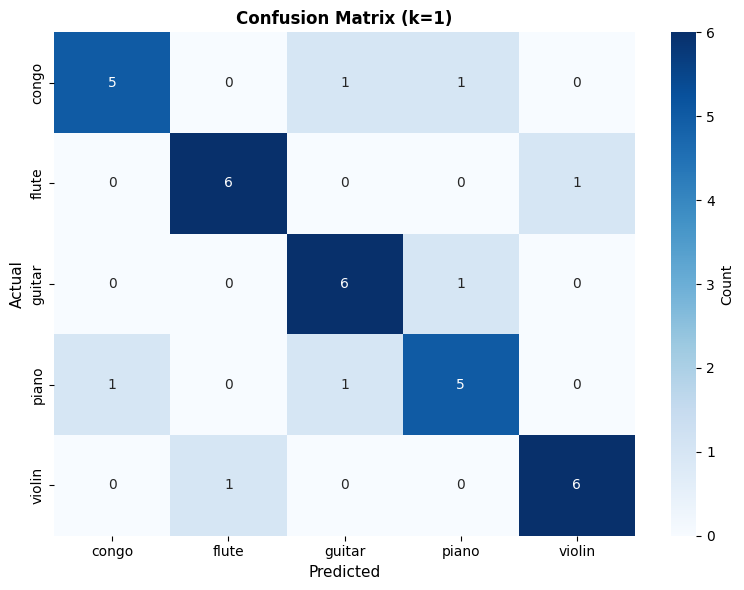


EXPLANATION

✓ Correctly classified: 28 / 35
✗ Misclassified: 7 / 35

Misclassified samples:
  Sample 1: congo → predicted as piano
  Sample 4: congo → predicted as guitar
  Sample 12: flute → predicted as violin
  Sample 16: guitar → predicted as piano
  Sample 21: piano → predicted as congo
  Sample 24: piano → predicted as guitar
  Sample 30: violin → predicted as flute

k-NN with k=1 achieved 80.0% accuracy
This means the classifier looks at the 1 nearest neighbor(s)
in the feature space to make its classification decision.



In [156]:
INSTRUMENTS = ['guitar', 'piano', 'congo', 'flute', 'violin']

print(f"\nDataset: {len(df)} samples, {len(INSTRUMENTS)} instruments")
print(f"Classes: {sorted(INSTRUMENTS)}")

# ============================================================================
# 1/5 - PREPARE FEATURES
# ============================================================================

feature_columns = [
    'spectral_centroid',
    'hfc',
    'dissonance',
    'mfcc_mean'
]

X = df[feature_columns].values
y = df['instrument'].values

print(f"\nUsing most discriminative features:")
for f in feature_columns:
    print(f"  - {f}")

# ============================================================================
# 2/5 - CHOOSE K VALUE
# ============================================================================

print("\n" + "="*80)
print("CHOOSING K VALUE")
print("="*80)

k_values = [1, 3, 5]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

loo_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    predictions = cross_val_predict(knn, X_scaled, y, cv=LeaveOneOut())
    accuracy = accuracy_score(y, predictions)
    loo_scores.append(accuracy)
    print(f"k={k}: Accuracy = {accuracy:.3f} ({accuracy*100:.1f}%)")

best_k = k_values[np.argmax(loo_scores)]
print(f"\nSelected k = {best_k}")

# ============================================================================
# 3/5 - TRAIN FINAL MODEL
# ============================================================================

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_scaled, y)
y_pred = cross_val_predict(knn_final, X_scaled, y, cv=LeaveOneOut())

final_accuracy = accuracy_score(y, y_pred)
print(f"\nFinal Accuracy: {final_accuracy:.3f} ({final_accuracy*100:.1f}%)")

# ============================================================================
# 4/5 - RESULTS
# ============================================================================

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print("\n" + classification_report(y, y_pred, target_names=sorted(INSTRUMENTS)))

# Confusion Matrix
cm = confusion_matrix(y, y_pred, labels=sorted(INSTRUMENTS))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(INSTRUMENTS), 
            yticklabels=sorted(INSTRUMENTS),
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('Actual', fontsize=11)
ax.set_title(f'Confusion Matrix (k={best_k})', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 5/5 - EXPLANATION
# ============================================================================

print("\n" + "="*80)
print("EXPLANATION")
print("="*80)

misclassified = (y != y_pred).sum()
print(f"\n✓ Correctly classified: {(y == y_pred).sum()} / {len(y)}")
print(f"✗ Misclassified: {misclassified} / {len(y)}")

if misclassified > 0:
    print("\nMisclassified samples:")
    results_df = pd.DataFrame({
        'actual': y,
        'predicted': y_pred,
    })
    wrong = results_df[y != y_pred]
    for idx in wrong.index:
        print(f"  Sample {idx}: {y[idx]} → predicted as {y_pred[idx]}")

print(f"\nk-NN with k={best_k} achieved {final_accuracy:.1%} accuracy")
print(f"This means the classifier looks at the {best_k} nearest neighbor(s)")
print("in the feature space to make its classification decision.")

print("\n" + "="*80)

### Now, classify our sound with this trained k-NN model

In [157]:
# Extract features using Essentia
extractor = es.MusicExtractor(lowlevelStats=['mean'])
features, _ = extractor(input_file)

# Extract same features used in training
spectral_centroid = features['lowlevel.spectral_centroid.mean']
hfc = features['lowlevel.hfc.mean']
dissonance = features['lowlevel.dissonance.mean']
mfcc_mean = np.mean(features['lowlevel.mfcc.mean'])

# Create feature vector
new_features = np.array([[spectral_centroid, hfc, dissonance, mfcc_mean]])

# Scale and predict
new_features_scaled = scaler.transform(new_features)
prediction = knn_final.predict(new_features_scaled)[0]
probabilities = knn_final.predict_proba(new_features_scaled)[0]

print(f"\nOur original sound {input_file.split('/')[-1]} is classified as: {prediction.title()}")


Our original sound flageolett_processed.wav is classified as: Piano


[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


### Explanation for classification
The acoustic bass was misclassified as piano likely due to similarities in their acoustic profiles across the key descriptors. Both instruments produce relatively low spectral centroids (bass frequencies are prominent in both), moderate dissonance values (both have harmonic overtone structures), and similar HFC (high-frequency content) characteristics when playing sustained notes. The MFCC mean values, which capture the overall timbre envelope, may overlap significantly between a plucked or bowed bass and a piano's struck strings, especially in their lower registers where both instruments share fundamental frequency ranges.